# ShrinkCRISPR

In [1]:
# Imports & options
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

print('Libraries ready')

Libraries ready


In [2]:
# Paths
project_root = Path('..').resolve().parent  # adjust if needed
data_dir = project_root / 'data'
fig_dir = project_root / 'outputs' / 'figures'
table_dir = project_root / 'outputs' / 'tables'

sgrna_file = data_dir / 'sgrna_summary.csv'

# Ensure outputs exist
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)

print('Data dir  :', data_dir)
print('Figures   :', fig_dir)
print('Tables    :', table_dir)
print('sgRNA file:', sgrna_file)

Data dir  : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data
Figures   : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures
Tables    : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables
sgRNA file: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data/sgrna_summary.csv


In [3]:
# Load sgRNA summary (wide format)
assert sgrna_file.exists(), f'Missing file: {sgrna_file}'
sgrna_wide = pd.read_csv(sgrna_file)
print(f'Loaded sgRNA rows: {len(sgrna_wide):,}')

# Peek
display(sgrna_wide.head())

# Required columns sanity check
required_cols = {'sgrna','Gene','control_count','treatment_count'}
missing = required_cols - set(sgrna_wide.columns)
assert not missing, f'Missing required columns: {missing}'

Loaded sgRNA rows: 77,487


,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
0,77449,FOXP3,181.16/186.77,10106/5287.9,183.96,7696.9,5.3792,15.7130,1576.90,189.19,1.0,0.0,0.0,0.0,True
1,17754,SMARCB1,81.278/78.442,4371/4091.6,79.86,4231.3,5.7099,4.0202,642.01,163.85,1.0,0.0,0.0,0.0,True
2,37463,FOXP3,102.82/143.81,7527.5/2948.8,123.32,5238.1,5.3972,840.0700,1025.00,159.76,1.0,0.0,0.0,0.0,True
3,77453,FOXP3,290.84/84.045,8696.1/3933.5,187.44,6314.8,5.0668,21381.0000,1609.10,152.75,1.0,0.0,0.0,0.0,True
4,77477,FOXP3,54.348/22.412,3420.9/1395.3,38.38,2408.1,5.9349,509.9600,291.78,138.73,1.0,0.0,0.0,0.0,True


In [4]:
# Helper to parse 'a/b' replicate fields into two floats

def _parse_two_reps(val):
    # Returns (rep1, rep2) as floats (np.nan if unavailable)
    if pd.isna(val):
        return np.nan, np.nan
    # Try string normalization
    try:
        s = str(val).strip()
    except Exception:
        return np.nan, np.nan
    parts = [p.strip() for p in s.split('/') if p.strip() != '']

    if len(parts) == 0:
        return np.nan, np.nan
    if len(parts) == 1:
        try:
            x = float(parts[0])
        except Exception:
            x = np.nan
        return x, x

    # len(parts) >= 2 → take first two entries
    try:
        a = float(parts[0])
    except Exception:
        a = np.nan
    try:
        b = float(parts[1])
    except Exception:
        b = np.nan
    return a, b

print("Helper _parse_two_reps ready")

Helper _parse_two_reps ready


In [5]:
# Parse replicate counts and attach numeric columns
ctrl_r1, ctrl_r2 = zip(*sgrna_wide['control_count'].map(_parse_two_reps))
trt_r1, trt_r2   = zip(*sgrna_wide['treatment_count'].map(_parse_two_reps))

sgrna_wide = sgrna_wide.assign(
    control_r1=pd.to_numeric(ctrl_r1, errors='coerce'),
    control_r2=pd.to_numeric(ctrl_r2, errors='coerce'),
    treatment_r1=pd.to_numeric(trt_r1, errors='coerce'),
    treatment_r2=pd.to_numeric(trt_r2, errors='coerce')
)

display(sgrna_wide[['sgrna','Gene','control_r1','control_r2','treatment_r1','treatment_r2']].head())

,sgrna,Gene,control_r1,control_r2,treatment_r1,treatment_r2
0,77449,FOXP3,181.160,186.770,10106.0,5287.9
1,17754,SMARCB1,81.278,78.442,4371.0,4091.6
2,37463,FOXP3,102.820,143.810,7527.5,2948.8
3,77453,FOXP3,290.840,84.045,8696.1,3933.5
4,77477,FOXP3,54.348,22.412,3420.9,1395.3


In [6]:
# Build tidy long-form count table (one row per sgRNA x sample)
# Assumptions:
# - treatment = FOXP3-low; control = FOXP3-high
# - Two replicates for each condition: r1, r2

rows = []
for _, row in sgrna_wide.iterrows():
    sg = row['sgrna']
    gene = row['Gene']
    # Control (FOXP3-high)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 1,
        'sample_id': 'control_r1',
        'count': row.get('control_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 2,
        'sample_id': 'control_r2',
        'count': row.get('control_r2', np.nan)
    })
    # Treatment (FOXP3-low)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 1,
        'sample_id': 'treatment_r1',
        'count': row.get('treatment_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 2,
        'sample_id': 'treatment_r2',
        'count': row.get('treatment_r2', np.nan)
    })

counts_long = pd.DataFrame(rows)

# Library-size normalization: per-sample size factors
lib_sizes = counts_long.groupby('sample_id')['count'].sum()
geom_mean = np.exp(np.log(lib_sizes.replace(0, np.nan)).mean())
size_factors = (lib_sizes / geom_mean).replace([np.inf, -np.inf], np.nan)
size_factors = size_factors.fillna(1.0)
size_factors = size_factors.rename('size_factor').reset_index()

# Add size factors (counts_long already has condition/replicate)
counts_long = counts_long.merge(size_factors, on='sample_id', how='left')

print('Tidy counts shape:', counts_long.shape)
print('Samples:', counts_long['sample_id'].unique())
print('NaN counts:', counts_long['count'].isna().sum())

display(counts_long.head())

Tidy counts shape: (309948, 7)
Samples: ['control_r1' 'control_r2' 'treatment_r1' 'treatment_r2']
NaN counts: 0


,sgrna,gene,condition,replicate,sample_id,count,size_factor
0,77449,FOXP3,control,1,control_r1,181.160,0.993118
1,77449,FOXP3,control,2,control_r2,186.770,0.999318
2,77449,FOXP3,treatment,1,treatment_r1,10106.000,1.002837
3,77449,FOXP3,treatment,2,treatment_r2,5287.900,1.004766
4,17754,SMARCB1,control,1,control_r1,81.278,0.993118


In [8]:
# QA/QC: Sample-level summaries
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

plt.style.use('arviz-docgrid')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)

# Totals, zeros, unique sgRNAs per sample
sample_totals = counts_long.groupby('sample_id')['count'].sum().rename('total_count')
zero_counts = (
    counts_long.assign(is_zero=(counts_long['count'] == 0))
    .groupby('sample_id')['is_zero']
    .sum()
    .rename('zero_count')
)
n_sgrna = counts_long.groupby('sample_id')['sgrna'].nunique().rename('n_sgrna')

# Size factors (already merged)
sf = (
    counts_long[['sample_id','size_factor']]
    .drop_duplicates()
    .set_index('sample_id')['size_factor']
)

summary = pd.concat([sample_totals, zero_counts, n_sgrna, sf], axis=1).reset_index()
summary['nonzero'] = summary['n_sgrna'] - summary['zero_count']

print('QA/QC — sample summary:')
display(summary)


QA/QC — sample summary:


,sample_id,total_count,zero_count,n_sgrna,size_factor,nonzero
0,control_r1,2.716991e+07,8,77487,0.993118,77479
1,control_r2,2.733954e+07,14,77487,0.999318,77473
2,treatment_r1,2.743582e+07,2,77487,1.002837,77485
3,treatment_r2,2.748858e+07,7,77487,1.004766,77480


In [9]:
# Save tidy counts to outputs/tables
out_path = table_dir / 'tidy_counts.csv'
counts_long.to_csv(out_path, index=False)
print(f'Saved tidy counts to: {out_path}')

Saved tidy counts to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/tidy_counts.csv


## ShrinkCRISPR pipeline
1) Configuration and helpers
2) sgRNA-level log2 fold-changes (paired)
3) Gene-level EB aggregation (DL τ²)
4) Save outputs
5) Volcano plot
6) Optional overlaps with NB NUTS / MAGeCK

In [10]:
# 1) Configuration and helpers
from dataclasses import dataclass
import numpy as np
import pandas as pd
from pathlib import Path

@dataclass
class ShrinkConfig:
    # Design and preprocessing
    paired: bool = True  # True = paired design (T0 cancels); False = independent design (need T0)
    pseudocount: float = 0.5
    lfc_base: float = 2.0
    use_rscreenorm: bool = False  # If True and control sets provided, compute rscreenorm-style lethality scores
    neg_ctrl_genes_path: Path | None = None  # optional path to a file listing negative control genes (one per line)
    pos_ctrl_genes_path: Path | None = None  # optional path to a file listing positive control genes (one per line)

    # Aggregation and testing
    min_guides_per_gene: int = 2
    alpha_lfdr: float = 0.10  # paper examples: lfdr 0.05 (sims), 0.10 (cisplatin)

    # Legacy thresholds (kept for compatibility/extra filters)
    lfsr_max: float = 0.15
    effect_thresh: float = 0.3
    prob_min: float = 0

    # Labels
    condition_levels: tuple[str, str] = ("control", "treatment")

CFG = ShrinkConfig()
print(CFG)

def benjamini_hochberg(pvals: pd.Series, alpha: float = 0.05) -> pd.Series:
    p = pvals.fillna(1.0).values
    n = len(p)
    order = np.argsort(p)
    ranked = np.empty(n)
    ranked[order] = np.arange(1, n + 1)
    q = p * n / ranked
    q_sorted = np.minimum.accumulate(q[order][::-1])[::-1]
    qvals = np.empty(n)
    qvals[order] = np.clip(q_sorted, 0, 1)
    return pd.Series(qvals, index=pvals.index, name='qval')

def _load_ctrl_gene_sets(neg_path: Path | None, pos_path: Path | None) -> tuple[set[str], set[str]]:
    neg, pos = set(), set()
    if neg_path and Path(neg_path).exists():
        neg = {ln.strip() for ln in Path(neg_path).read_text().splitlines() if ln.strip()}
    if pos_path and Path(pos_path).exists():
        pos = {ln.strip() for ln in Path(pos_path).read_text().splitlines() if ln.strip()}
    return neg, pos

ShrinkConfig(paired=True, pseudocount=0.5, lfc_base=2.0, use_rscreenorm=False, neg_ctrl_genes_path=None, pos_ctrl_genes_path=None, min_guides_per_gene=2, alpha_lfdr=0.1, lfsr_max=0.15, effect_thresh=0.3, prob_min=0, condition_levels=('control', 'treatment'))


In [11]:
# 2) sgRNA-level effects: from normalized counts to LFC or rscreenorm lethality
# Paper options:
# - Paired design: compare treated vs control replicates (T0 cancels). We compute LFC per sgRNA×replicate.
# - Independent design: include T0 to form fold changes first; optional rscreenorm to map to lethality in [0,1].

# We currently have counts for end-point only; no explicit T0 columns in this dataset.
# For this notebook, we implement the paired design path and optional rscreenorm scaffolding if control sets exist.

df = counts_long.copy()
cond_ctrl, cond_trt = CFG.condition_levels
keep_cols = ['sgrna','gene','condition','replicate','sample_id','count','size_factor']
df = df[keep_cols].dropna(subset=['count']).copy()
df['norm_count'] = df['count'] / df['size_factor'].replace(0, np.nan)

# Pivot by condition for each sgRNA×replicate
ctrl = (
    df[df['condition'] == cond_ctrl]
    .pivot_table(index=['sgrna','gene','replicate'], columns='condition', values='norm_count', aggfunc='first')
)
trt = (
    df[df['condition'] == cond_trt]
    .pivot_table(index=['sgrna','gene','replicate'], columns='condition', values='norm_count', aggfunc='first')
)
idx = ctrl.index.union(trt.index)
x = ctrl.reindex(idx).get(cond_ctrl)
y = trt.reindex(idx).get(cond_trt)

pc = CFG.pseudocount
base = CFG.lfc_base
lfc = np.log((y + pc) / (x + pc)) / np.log(base)
lfc = pd.Series(lfc, index=idx, name='effect').reset_index()
lfc['metric'] = 'lfc'

# Optional rscreenorm-like lethality mapping if control gene sets available (scaffolding)
neg_set, pos_set = _load_ctrl_gene_sets(CFG.neg_ctrl_genes_path, CFG.pos_ctrl_genes_path)
if CFG.use_rscreenorm and (neg_set or pos_set):
    # Use medians of fold change within control sets
    lfc_ctrl = lfc.copy()
    # Compute gene medians over sgRNAs for control sets to stabilize
    lfc_ctrl_gene = (
        lfc_ctrl.groupby('gene')['effect'].median().rename('gene_median').reset_index()
    )
    lfc_ctrl = lfc_ctrl.merge(lfc_ctrl_gene, on='gene', how='left')
    fcneg = lfc_ctrl.loc[lfc_ctrl['gene'].isin(neg_set), 'gene_median'].median()
    fcpos = lfc_ctrl.loc[lfc_ctrl['gene'].isin(pos_set), 'gene_median'].median()
    if np.isfinite(fcneg) and np.isfinite(fcpos) and (fcpos != fcneg):
        # Map to [0,1]: ls = (lfc - fcneg) / (fcpos - fcneg)
        lfc['effect'] = (lfc['effect'] - fcneg) / (fcpos - fcneg)
        lfc['metric'] = 'lethality'
        print('Applied rscreenorm-like mapping using provided control sets')
    else:
        print('Control set medians not usable; keeping LFC metric')

# Filter genes by min guides
guide_counts = lfc.groupby('gene')['sgrna'].nunique()
keep_genes = guide_counts[guide_counts >= CFG.min_guides_per_gene].index
lfc = lfc[lfc['gene'].isin(keep_genes)].copy()
print('sgRNA effects:', len(lfc), '| genes kept:', len(keep_genes), '| metric:', lfc['metric'].iloc[0] if len(lfc) else 'NA')

sgRNA effects: 154972 | genes kept: 19112 | metric: lfc


In [12]:
# 3) Gene-level EB aggregation
# Paper alignment:
# - Mixed-effects EB via ShrinkBayes/INLA in the paper; here we approximate at gene-level with RE (DL tau^2).
# - Prior mean centered at 0 (no differential lethality), not at a weighted grand mean across genes.
# - Primary decision metric is lfdr (local fdr from Bayes factors in paper). We approximate with two-sided normal p and BH q.

from scipy.stats import norm

# Aggregate per gene
g = lfc.groupby('gene')
mu_g = g['effect'].mean().rename('effect_mean')
s2_g = g['effect'].var(ddof=1).rename('effect_var')
k_g = g['effect'].size().rename('k')
gene_df = pd.concat([mu_g, s2_g, k_g], axis=1).reset_index()
# Variance of the gene mean (within-gene): s^2 / k
gene_df['effect_var'] = gene_df['effect_var'].fillna(gene_df['effect_var'].median())
gene_df['sigma2'] = np.clip(gene_df['effect_var'] / gene_df['k'].clip(lower=1), 1e-8, np.inf)

# DerSimonian–Laird tau^2 across genes (heterogeneity) using inverse-variance weights
w_fe = 1.0 / gene_df['sigma2'].values
mu0_fe = np.sum(w_fe * gene_df['effect_mean'].values) / np.sum(w_fe)
Q = np.sum(w_fe * (gene_df['effect_mean'].values - mu0_fe) ** 2)
df_Q = len(gene_df) - 1
C = np.sum(w_fe) - (np.sum(w_fe**2) / np.sum(w_fe))
tau2 = max((Q - df_Q) / max(C, 1e-12), 0.0)

# EB posterior with prior N(0, tau2) centered at 0 (null: no differential effect)
y = gene_df['effect_mean'].values
sigma2 = gene_df['sigma2'].values
if tau2 > 0:
    w_obs = 1.0 / sigma2
    w_pri = 1.0 / tau2
    post_mean = (w_obs * y + w_pri * 0.0) / (w_obs + w_pri)
    post_var = 1.0 / (w_obs + w_pri)
else:
    post_mean = y.copy()
    post_var = sigma2.copy()
post_se = np.sqrt(np.clip(post_var, 1e-12, np.inf))

# Wald z, two-sided p, BH q as lfdr proxy
z = post_mean / np.clip(post_se, 1e-12, np.inf)
p_two = 2.0 * np.minimum(norm.cdf(z), 1 - norm.cdf(z))
qvals = benjamini_hochberg(pd.Series(p_two, index=gene_df.index), alpha=CFG.alpha_lfdr)

# Save columns
gene_df['tau2'] = tau2
gene_df['post_mean'] = post_mean
gene_df['post_se'] = post_se
gene_df['z'] = z
gene_df['p_two'] = p_two
gene_df['lfdr'] = qvals.values  # using BH q as practical lfdr substitute

# Additional probability and legacy hit rule (optional secondary filter)
thr = CFG.effect_thresh
p_pos = 1 - norm.cdf((thr - gene_df['post_mean']) / gene_df['post_se'])
p_neg = norm.cdf((-thr - gene_df['post_mean']) / gene_df['post_se'])
gene_df['p_abs_ge_thr'] = (p_pos + p_neg).clip(0, 1)

# Primary hit call per paper: lfdr <= alpha
hit_primary = gene_df['lfdr'] <= CFG.alpha_lfdr
# Optional stricter rule (intersection) to be conservative in small-n settings
hit_legacy = (gene_df['p_abs_ge_thr'] >= CFG.prob_min)

gene_df['hit'] = hit_primary & hit_legacy

# Diagnostics
I2 = max((Q - df_Q) / max(Q, 1e-12), 0.0)
print(f"DL diagnostics — Q: {Q:.4g}, df: {df_Q}, C: {C:.4g}, Q-df: {Q - df_Q:.4g}, tau^2: {tau2:.4g}, I^2: {I2:.2%}")
print(f"Genes: {len(gene_df)} | primary hits (lfdr≤{CFG.alpha_lfdr}): {int(hit_primary.sum())} | final hits (∩ legacy): {int(gene_df['hit'].sum())}")
display(gene_df.head())

DL diagnostics — Q: 4.182e+04, df: 19111, C: 1.064e+06, Q-df: 2.271e+04, tau^2: 0.02134, I^2: 54.31%
Genes: 19112 | primary hits (lfdr≤0.1): 278 | final hits (∩ legacy): 278


,gene,effect_mean,effect_var,k,sigma2,tau2,post_mean,post_se,z,p_two,lfdr,p_abs_ge_thr,hit
0,2023-03-01 00:00:00,0.127203,0.149006,16,0.009313,0.021339,0.088555,0.080519,1.099799,0.271420,0.999944,0.004320,False
1,2023-03-02 00:00:00,-0.104076,0.247451,16,0.015466,0.021339,-0.060342,0.094694,-0.637239,0.523969,0.999944,0.005760,False
2,2023-03-03 00:00:00,-0.138387,0.363821,8,0.045478,0.021339,-0.044196,0.120516,-0.366726,0.713824,0.999944,0.019040,False
3,2023-03-04 00:00:00,0.205952,0.184979,8,0.023122,0.021339,0.098846,0.105345,0.938310,0.348085,0.999944,0.028176,False
4,2023-03-05 00:00:00,-0.213657,0.145239,8,0.018155,0.021339,-0.115442,0.099042,-1.165585,0.243782,0.999944,0.031214,False


In [13]:
# 4) Save outputs
shrink_gene_summary = gene_df.copy()
# Column was renamed to lfdr (BH q); keep a backward-compatible alias
shrink_gene_summary = shrink_gene_summary.rename(columns={'lfdr':'lfdr'})
shrink_hits = shrink_gene_summary.loc[shrink_gene_summary['hit'], ['gene','post_mean','lfdr','p_abs_ge_thr']]
p_gene = table_dir / 'shrinkcrispr_gene_summary.csv'
p_hits = table_dir / 'hits_shrinkcrispr.csv'
shrink_gene_summary.to_csv(p_gene, index=False)
shrink_hits.to_csv(p_hits, index=False)
print(f'Saved:\n  {p_gene}\n  {p_hits} (n={len(shrink_hits)})')

Saved:
  /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/shrinkcrispr_gene_summary.csv
  /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_shrinkcrispr.csv (n=278)


Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/volcano_plot_shrinkcrispr.png


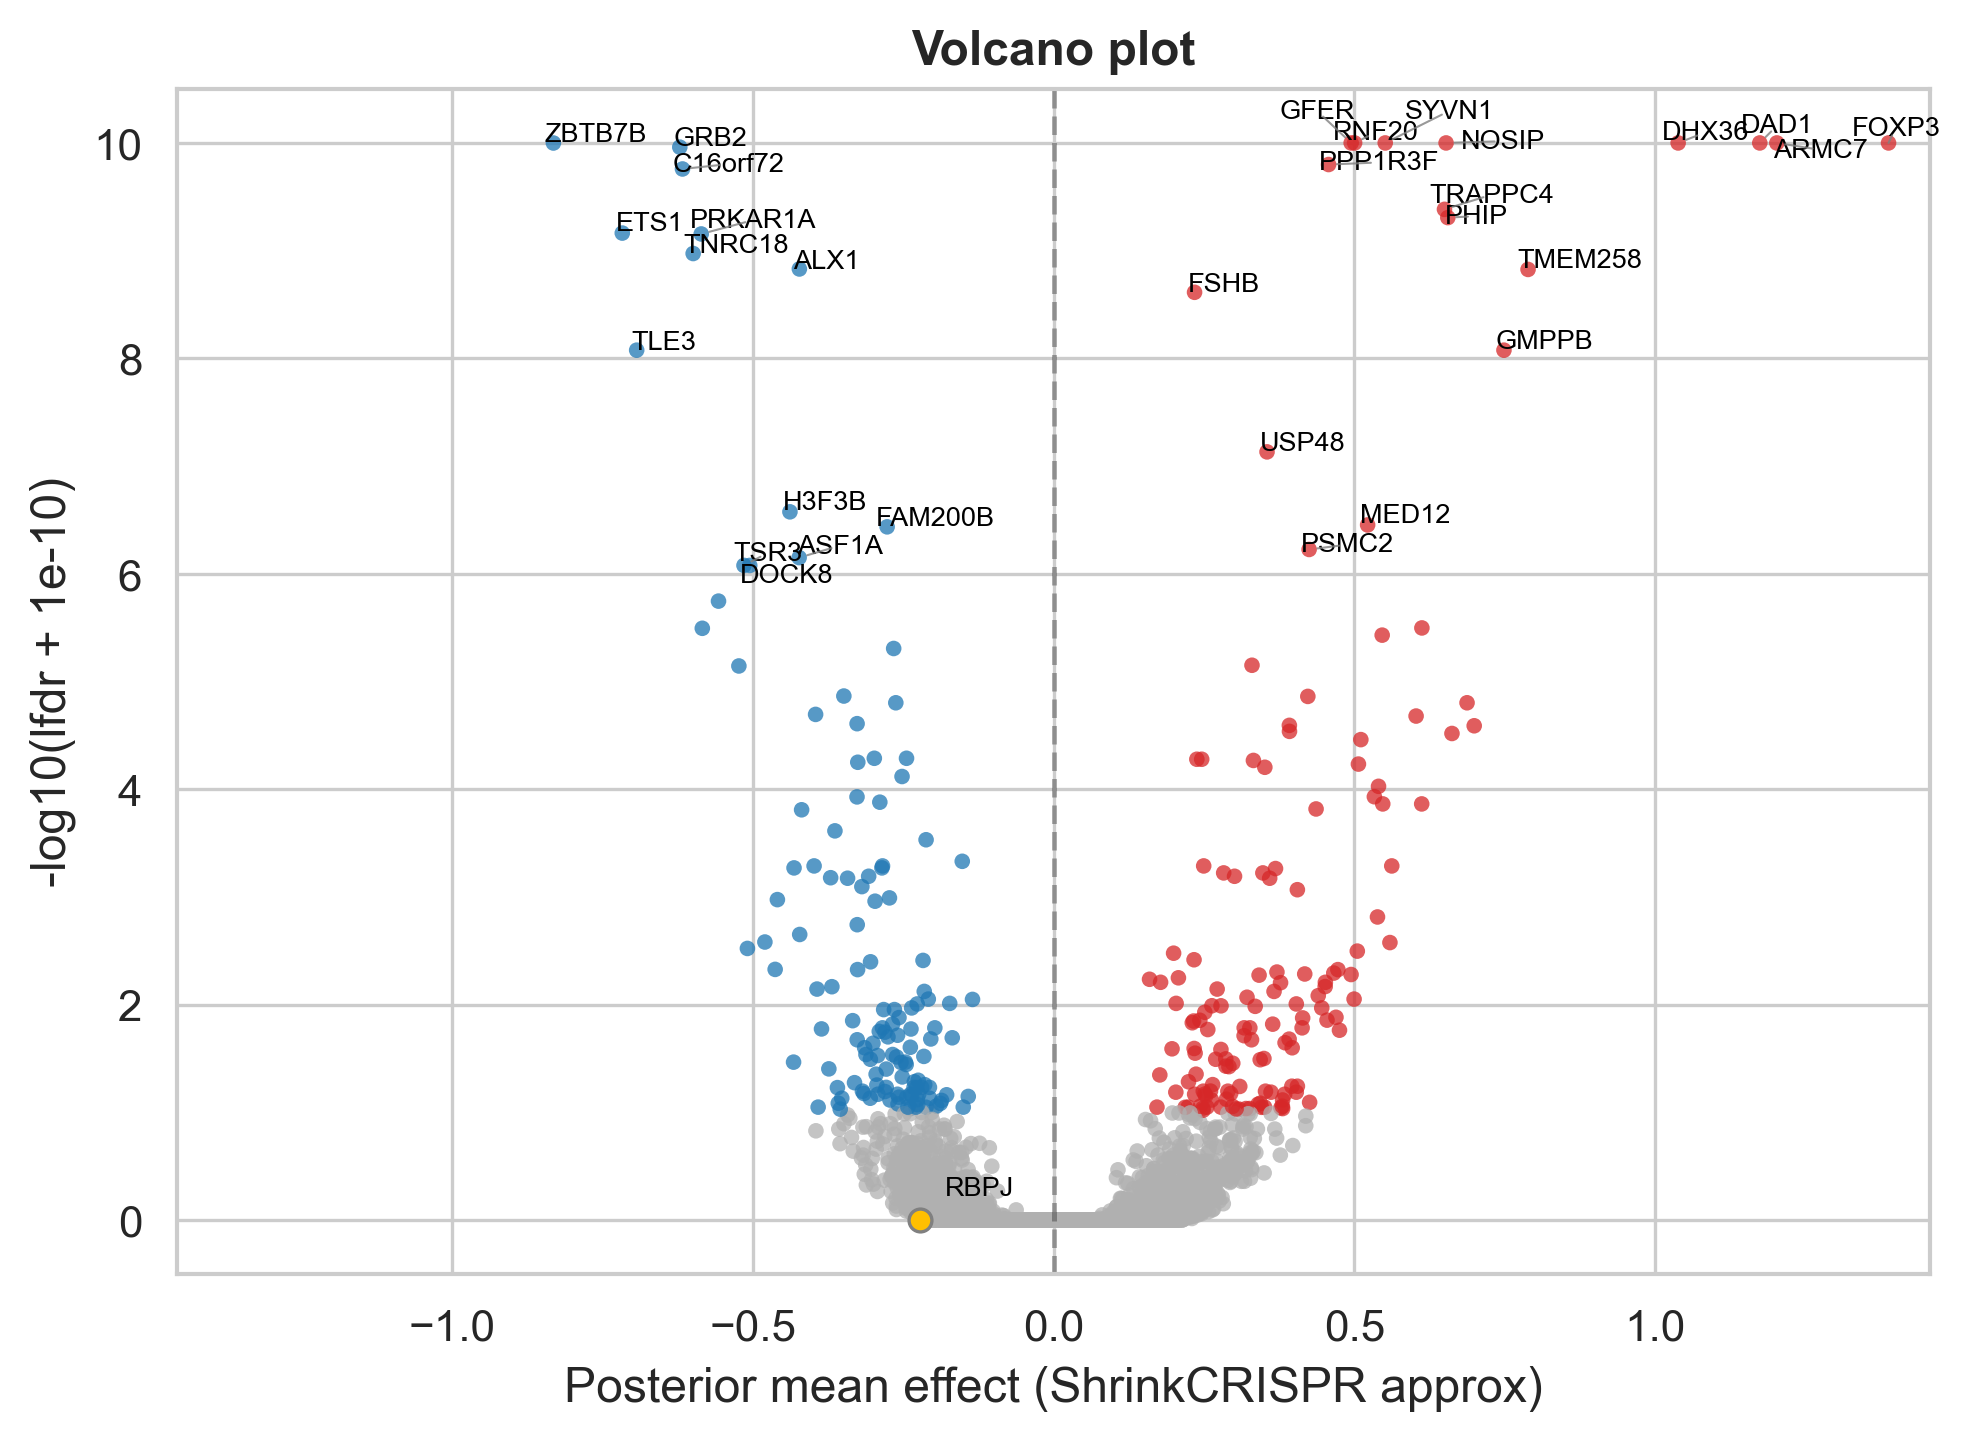

In [21]:
# 5) Volcano plot
import matplotlib.pyplot as plt
import numpy as np

_dfv = shrink_gene_summary.copy()
x = _dfv['post_mean'].astype(float).values
# Use -log10(lfdr) with epsilon to avoid inf; color non-hits gray
y = -np.log10(np.clip(_dfv['lfdr'].astype(float).values, 1e-300, 1.0) + 1e-10)
hits = _dfv['hit'].fillna(False).values
colors = np.where(hits, np.where(x >= 0, '#d62728', '#1f77b4'), '#b0b0b0')

plt.figure(figsize=(8,6))
plt.scatter(x, y, c=colors, s=14, alpha=0.75, linewidths=0)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
xmax = float(np.nanmax(np.abs(x))) if x.size else 1.0
if np.isfinite(xmax) and xmax > 0:
    plt.xlim(-1.05 * xmax, 1.05 * xmax)

# Optional labels for top points (uses adjustText if available)
try:
    from adjustText import adjust_text
    _have_adjust = True
except Exception:
    _have_adjust = False

# Determine label column heuristically
label_col = None
for cand in ['gene','Gene','gene_symbol','label','name']:
    if cand in _dfv.columns:
        label_col = cand
        break

# If label column present, annotate top points
if label_col is not None and len(_dfv) > 0:
    temp = _dfv.copy()
    temp[label_col] = temp[label_col].astype(str)
    temp['neglog10_lfdr'] = -np.log10(np.clip(temp['lfdr'].astype(float).values, 1e-300, 1.0) + 1e-10)
    
    top_k = min(30, len(temp))
    top = temp.nlargest(top_k, 'neglog10_lfdr')
    
    texts = []
    for _, row in top.iterrows():
        texts.append(plt.text(
            float(row['post_mean']), 
            float(row['neglog10_lfdr']), 
            row[label_col], 
            fontsize=6.5,
            color='black'
        ))

    adjust_text(
        texts, 
        lim=1000, 
        force_text=(0.2, 0.25),
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.8)
    )

# Highlight RBPJ (gold star marker with label)
try:
    _rbpj = _dfv[_dfv['gene'].astype(str).str.upper() == 'RBPJ']
    if len(_rbpj):
        _x_r = float(_rbpj['post_mean'].iloc[0])
        _y_r = -np.log10(np.clip(float(_rbpj['lfdr'].iloc[0]), 1e-300, 1.0) + 1e-6)
        plt.scatter([_x_r], [_y_r], s=30, c='#ffbf00', edgecolors='gray', linewidths=0.8, zorder=5)
        plt.annotate('RBPJ', (_x_r, _y_r), xytext=(6, 6), textcoords='offset points', fontsize=6.5,  color='black')
    else:
        print('RBPJ not found in shrink_gene_summary; no highlight added.')
except Exception as e:
    print(f'RBPJ highlight skipped due to error: {e}')

plt.xlabel('Posterior mean effect (ShrinkCRISPR approx)')
plt.ylabel('-log10(lfdr + 1e-10)')
plt.title('Volcano plot')
plt.tight_layout()
out_fig = fig_dir / 'volcano_plot_shrinkcrispr.png'
plt.savefig(out_fig, dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_fig}')
plt.show()


In [15]:
# 6) Overlaps with HBM NUTS and MAGeCK (if present)
from pathlib import Path
import pandas as pd

nuts_hits_path = table_dir / 'hits_hbm_nuts.csv'
mageck_labels1 = table_dir / 'bench_reference_labels.csv'
mageck_labels2 = table_dir / 'bench_mageck_hits.csv'

shrink_set = set(shrink_hits['gene'].astype(str))
nuts_set = set()
mageck_set = set()

if nuts_hits_path.exists():
    nd = pd.read_csv(nuts_hits_path)
    if {'gene','hit'}.issubset(nd.columns):
        nuts_set = set(nd.loc[nd['hit'], 'gene'].dropna().astype(str))
    elif 'gene' in nd.columns:
        nuts_set = set(nd['gene'].dropna().astype(str))

if mageck_labels1.exists():
    mg = pd.read_csv(mageck_labels1)
    if {'gene','label'}.issubset(mg.columns):
        mageck_set = set(mg.loc[mg['label'].astype(bool), 'gene'].dropna().astype(str))
elif mageck_labels2.exists():
    mg = pd.read_csv(mageck_labels2)
    if {'gene','hit'}.issubset(mg.columns):
        mageck_set = set(mg.loc[mg['hit'].astype(bool), 'gene'].dropna().astype(str))

common_nuts = sorted(shrink_set & nuts_set)
common_mageck = sorted(shrink_set & mageck_set)
only_shrink = sorted(shrink_set - nuts_set - mageck_set)

out1 = table_dir / 'overlap_shrinkcrispr_and_hbm_nuts.csv'
out2 = table_dir / 'overlap_shrinkcrispr_and_mageck.csv'
out3 = table_dir / 'overlap_shrinkcrispr_only.csv'
pd.DataFrame({'gene': common_nuts}).to_csv(out1, index=False)
pd.DataFrame({'gene': common_mageck}).to_csv(out2, index=False)
pd.DataFrame({'gene': only_shrink}).to_csv(out3, index=False)
print(f'Saved overlaps:\n  {out1}\n  {out2}\n  {out3}')


Saved overlaps:
  /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_shrinkcrispr_and_hbm_nuts.csv
  /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_shrinkcrispr_and_mageck.csv
  /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/overlap_shrinkcrispr_only.csv
